In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

timestamps = pd.read_csv("./handshake.csv")
display(
    timestamps.groupby(["kex", "auth"]).size(
    ).reset_index(name="count").sort_values(["kex", "auth"])
)

,kex,auth,count
0,hqc128,mldsa44-mldsa44-mldsa44,3166
1,hqc128,sphincs128f-mldsa44-mldsa44,3105
2,mlkem512,mldsa44-mldsa44-mldsa44,3191
3,mlkem512,sphincs128f-mldsa44-mldsa44,3317
4,secp256r1,rsa2048-rsa2048-rsa2048,3017
5,secp256r1,sha256ecdsa-sha256ecdsa-sha256ecdsa,3004
6,x25519,ed25519-ed25519-ed25519,3026


kex                                 auth    kex_dur             \
                                                      median        P90   
2   mlkem512              mldsa44-mldsa44-mldsa44    26261.0    47400.0   
6     x25519              ed25519-ed25519-ed25519    36322.5    87552.0   
4  secp256r1              rsa2048-rsa2048-rsa2048   445229.0   463153.0   
5  secp256r1  sha256ecdsa-sha256ecdsa-sha256ecdsa   445006.0   467945.8   
0     hqc128              mldsa44-mldsa44-mldsa44  1341968.5  1360452.0   
3   mlkem512          sphincs128f-mldsa44-mldsa44    30113.0    42936.0   
1     hqc128          sphincs128f-mldsa44-mldsa44  1341327.0  1366833.2   

                           auth_dur                                    \
          P99        std     median        P90         P99        std   
2  2593131.20  485318.91   118950.0   120291.0   122078.90  164288.92   
6  4591476.50  713456.00    80999.5    81218.5    81464.00     177.74   
4   544504.28   17727.97    83073.0    83398.4    90403.56    3658.47   
5   548935.07  276277.61   457164.5   458945.8   460279.44    1474.15   
0  1435614.30  379439.78   119331.0   120369.5   121504.85     817.72   
3    75461.40   56242.69  1241805.0  1243345.0  1243729.72    1413.21   
1  1440076.44  351378.91  1238783.0  1239321.6  1242394.80     680.06   

      hs_dur                                    
      median        P90         P99        std  
2   169816.0   211286.0  3913537.40  537176.71  
6   325062.5   420183.0  4848693.50  770088.22  
4   551049.0   632314.8   705252.92   65015.36  
5   933640.5   985772.8  1238190.52  298411.88  
0  1493650.5  1512100.5  1596052.00  380640.40  
3  1537897.0  1630762.6  1724179.00  130269.70  
1  2639381.0  2682262.6  2842547.80  430761.00

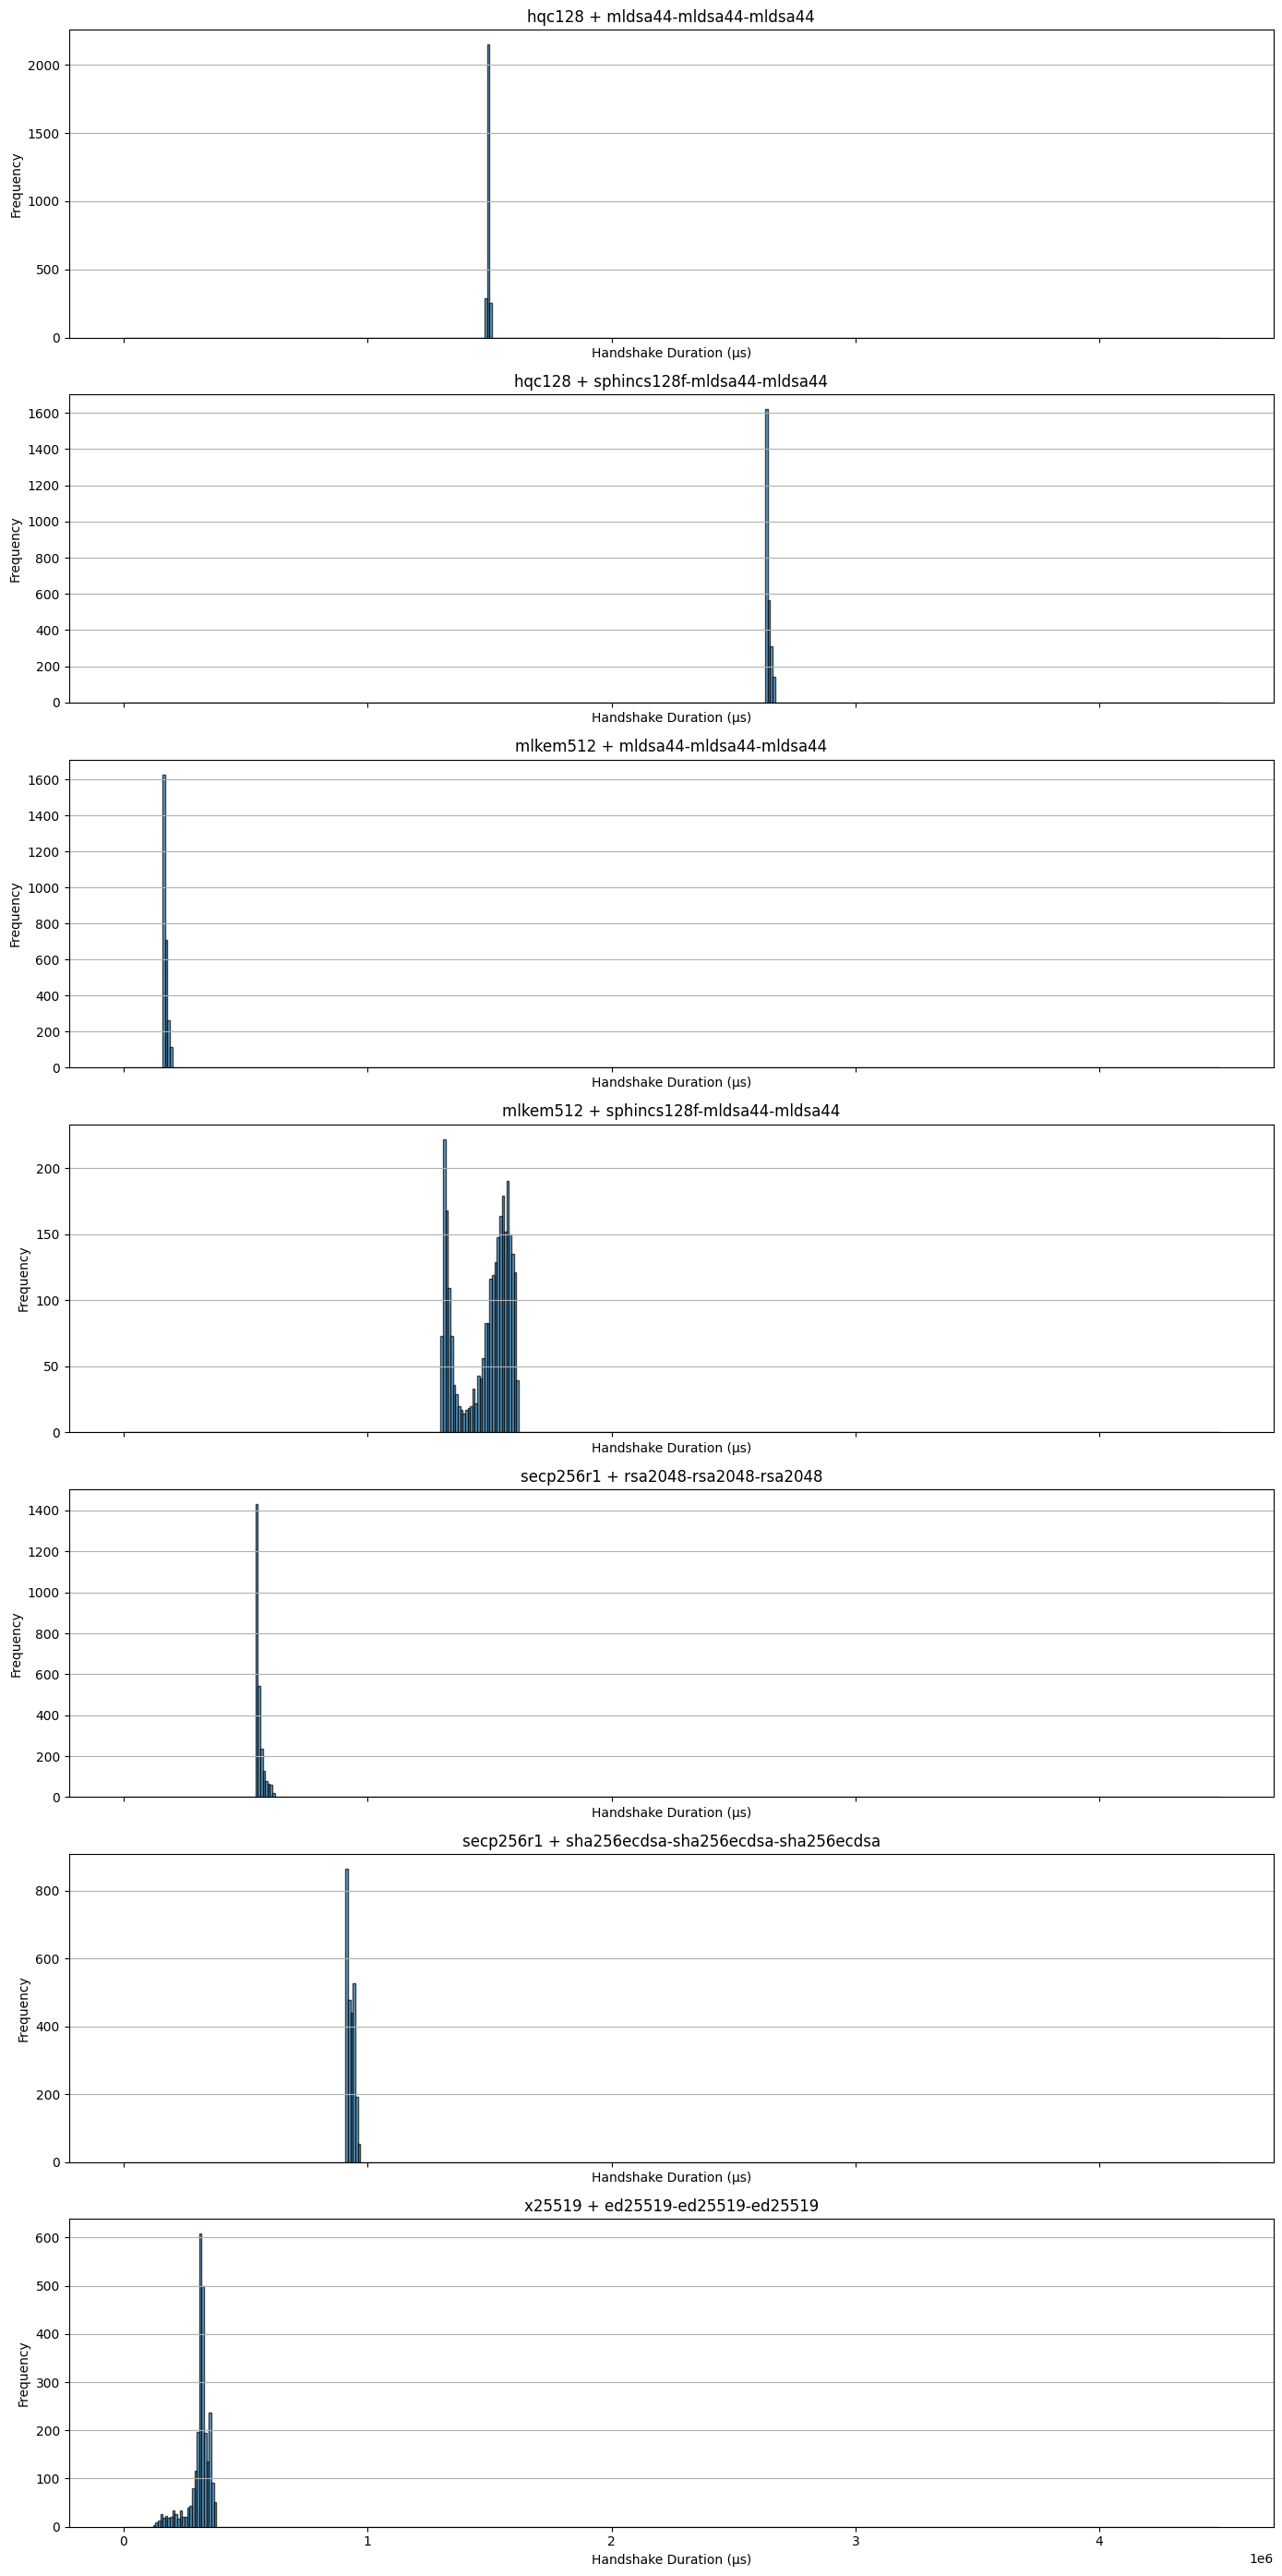

In [2]:
stats = timestamps.copy()
# compute durations and validate
stats["kex_dur"] = stats["sh_done"] - stats["ch_start"]
assert (stats["kex_dur"] > 0).all(), "non-positive key exchange duration"
stats["auth_dur"] = stats["auth_done"] - stats["auth_start"]
assert (stats["auth_dur"] > 0).all(), "non-positive authentication duration"
stats["hs_dur"] = stats["auth_done"] - stats["ch_start"]
assert (stats["hs_dur"] > 0).all(), "non-positive handshake duration"

def get_aggregate(stats: pd.DataFrame):
    # TODO: remove outliers based on handshake time

    # compute statistic
    p90 = lambda x: np.percentile(x, 90)
    p99 = lambda x: np.percentile(x, 99)
    summary = stats.groupby(["kex", "auth"])[
        ["kex_dur", "auth_dur", "hs_dur"]
        ].agg(
            ["median", p90, p99, "std"]
        ).reset_index().rename(columns={
            "<lambda_0>": "P90", "<lambda_1>": "P99"
        }).round(2).sort_values(("hs_dur", "median"))  
    
    return summary

display(get_aggregate(stats))

bins = [x for x in range(0, 4_500_000, 10_000)]
stats["group"] = stats["kex"] + " + " + stats["auth"]

# Unique groups and layout
groups = stats["group"].sort_values().unique()
n_groups = len(groups)
n_cols = 1
n_rows = math.ceil(n_groups / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)
axes = axes.flatten()  # Flatten in case of single row

# Plot each group in its own subplot
for idx, group_label in enumerate(groups):
    ax = axes[idx]
    group_df = stats[stats["group"] == group_label]
    group_upper = group_df["hs_dur"].quantile(1 - 15 / 100)
    group_df = group_df.loc[group_df["hs_dur"] < group_upper]
    ax.hist(group_df["hs_dur"], bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(group_label)
    ax.set_xlabel("Handshake Duration (μs)")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y')

# Hide unused subplots if any
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()